In [14]:
import sys
sys.path.append('../..')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_aer import AerSimulator 
from qiskit.utils import QuantumInstance
from qubap.qiskit.luciano.costfunc_barren_plateaus import global2local, test_hamiltonian, VQE_shift 
from qubap.qiskit.luciano.variational_algorithms import VQE, energy_evaluation, classical_solver
from qubap.qiskit.jorge.tools import SPSA_calibrated, make_list_and_callback

In [16]:
num_qubits = 8
hamiltonian_global = test_hamiltonian( num_qubits, [0,0,1] )
hamiltonian_global

PauliSumOp(SparsePauliOp(['ZZZZZZZZ'],
              coeffs=[1.+0.j]), coeff=1.0)

In [17]:
classical_solution = classical_solver( hamiltonian_global ).eigenvalue
classical_solution

(-1+0j)

In [18]:
hamiltonian_local = global2local( hamiltonian_global )
hamiltonian_local

PauliSumOp(SparsePauliOp(['IIIIIIIZ', 'IIIIIIZI', 'IIIIIZII', 'IIIIZIII', 'IIIZIIII', 'IIZIIIII', 'IZIIIIII', 'ZIIIIIII'],
              coeffs=[0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j, 0.125+0.j,
 0.125+0.j, 0.125+0.j]), coeff=1.0)

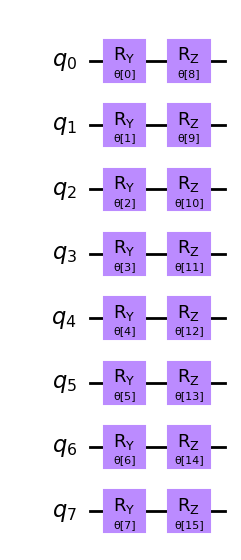

In [19]:
reps   = 0
ansatz = EfficientSU2( num_qubits, ['ry','rz'], 'circular', reps ).decompose()
ansatz.draw('mpl') 

In [20]:
npars = 2*num_qubits*( reps + 1 )
pars  = np.random.randn( npars ) * np.pi
quantum_instance = QuantumInstance( AerSimulator() , shots = 2**4 )

In [21]:
energy_evaluation( hamiltonian_global, ansatz, pars, quantum_instance )

-0.375

In [22]:
num_iters = 300

In [23]:
results_global = VQE( hamiltonian_global, ansatz, pars, num_iters, quantum_instance )
data_global    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') ) for x in results_global ]

In [24]:
results_shift = VQE_shift( hamiltonian_global, ansatz, pars, num_iters, num_iters//3, quantum_instance ) 
data_shift    = [ energy_evaluation( hamiltonian_global, ansatz, x, AerSimulator(method='statevector') )  for x in results_shift ] 

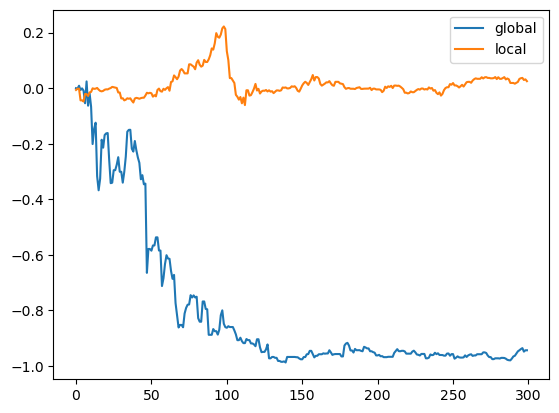

In [25]:
plt.plot( data_global )
plt.plot( data_shift  )
# plt.hlines( classical_solution, 0, num_iters, 'r' )
plt.legend(['global','local'])